Make sure to set all parameters in this top cell. Included in the repository are the Biagi, Puech, and BSR databases. All have a minimum indexing eV of 0.001. Biagi has a maximum indexing eV of 950, BSR has a maximum indexing eV of 300, and Puech has a maximum indexing eV of 150.

In [1]:
import numpy as np
import scipy.interpolate as interpolate
import math
import re
import glob
from matplotlib import pyplot as plt
import os
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D

database = 'LAr' # Will use the cross-sections contained in cross-sections/{database}
eV_min = 2.00e-3      # The minimum eV addressable using this dataset
eV_max = 3.00e2     # The maximum eV addressable using this dataset
eV_steps = 1000    # The number of steps to break each cross-section LUT into
angle_min = 0.0
angle_max = 180.0
angle_steps = 180

In [2]:
m_e = 9.1e-31

def E_to_v(eV):
    return np.sqrt((2 * eV * 1.60218e-19) / (m_e))

# Low eV energy-independent LAr cross-sections that merge with the (single) momentum-transfer GAr cross-section at several eV (see Wojcik and Tachiya)
def liquid_sigma_e(eV, gas_sigma_p):
    if eV < 3.85:
        return 5.5e-16
    return gas_sigma_p(eV)

def liquid_sigma_p(eV, S, gas_sigma_p):
    if eV < 4.6:
        return S(eV) * 5.5e-16
    return gas_sigma_p(eV)

eV_list = np.logspace(np.log10(eV_min), np.log10(eV_max), eV_steps)
angle_list = np.linspace(angle_min, angle_max, angle_steps)

The below cell imports the necessary files and creates the functions used to modify the GAr momentum-transfer cross-section.

# 1D momentum-transfer XSEC

In [3]:
sigma_p_eVs_1D, sigma_p_1D = np.loadtxt(f'cross-sections/BSR/momentum_xsec.txt', unpack=True)  # m^2
sigma_p_1D *= 1e4                                                                                  # to cm^2
#print(sigma_p)
sigma_p_func_1D = interpolate.interp1d(sigma_p_eVs_1D, sigma_p_1D, kind='slinear', fill_value=(0., 0.), bounds_error=False)

# Subset where the energy is greater than 10 eV
sub_indices = np.where(sigma_p_eVs_1D > 11.65)
sigma_p_eVs_1D_sub = np.array( [sigma_p_eVs_1D[n] for n in sub_indices[0]] )
sigma_p_1D_sub = np.array( [sigma_p_1D[n] for n in sub_indices[0]] )

# 2D SRC XSEC

In [4]:
#Elastic differential cross sections
sigma_e_angle,sigma_e_eVs, sigma_e = np.loadtxt(f'diff-cross-sections/{database}/DCS_scr.txt', unpack=True) # cm^2
reduced_list_e = sigma_e_eVs[::181]
#Integrate out the /sr to cm^2
angle = 0.0
for i in np.arange(len(sigma_e)):
    angle1rad = (math.pi/180.0)*angle
    angle2 = angle-1
    angle2rad = (math.pi/180.0)*angle2
    cost = 2 * math.pi * (math.cos(angle2rad)-math.cos(angle1rad))
    #print ('angle1 : %.01f & angle2 %.01f. Jac : %.02f'%(angle,angle2,cost))
    #cost = (1.0 - math.cos(angle_rad))*(1.0/4.0*math.pi)
    #if(angle > 0):
    #    cost = 2.0*math.pi*(0.25*(-math.cos((angle_1*math.pi)/90.0) - 4.0*math.cos((angle*math.pi)/180.0) + math.cos((angle*math.pi)/90.0)) + math.cos((angle_1*math.pi)/180.0))
    sigma_e[i] *= cost
    angle += 1
    if(angle == 181.0):
        angle = 0.0

sigma_e_func = np.add.reduceat(sigma_e, np.arange(0,len(sigma_e),181))

# 2D COH XSEC

In [5]:
#Momentum differential cross sections
sigma_p_angle,sigma_p_eVs, sigma_p = np.loadtxt(f'diff-cross-sections/{database}/DCS_coh.txt', unpack=True) # cm^2
reduced_list_p = sigma_p_eVs[::181]
#Integrate out the /sr to cm^2
angle = 0.0
for i in np.arange(len(sigma_p)):
    angle1rad = (math.pi/180.0)*angle
    angle2 = angle-1
    angle2rad = (math.pi/180.0)*angle2
    cost = 2 * math.pi * (math.cos(angle2rad)-math.cos(angle1rad))
    #cost = (1.0 - math.cos(angle_rad))*(1.0/4.0*math.pi)
    #if(angle > 0):
    #    cost = 2.0*math.pi*(0.25*(-math.cos((angle_1*math.pi)/90.0) - 4.0*math.cos((angle*math.pi)/180.0) + math.cos((angle*math.pi)/90.0)) + math.cos((angle_1*math.pi)/180.0))
    sigma_p[i] *= cost
    angle += 1
    if(angle == 181.0):
        angle = 0.0

sigma_p_func = np.add.reduceat(sigma_p, np.arange(0,len(sigma_p),181))

# Prepare input for .h File

In [6]:
angle_lists = np.arange(181)

counter = 0
entry_p = np.full((len(reduced_list_p)+len(sigma_p_eVs_1D_sub), angle_steps+3),0.)
for i in np.arange(len(reduced_list_p)):
    for j in np.arange(angle_steps+3):
        if(j == 0):
            if (reduced_list_p[i] < eV_min):
                eV_min = reduced_list_p[i]
            entry_p[i,j] = reduced_list_p[i]
        elif(j == 1):
            entry_p[i,j] = sigma_p_func[i]
        else:
            entry_p[i,j] = sigma_p[counter]/sigma_p_func[i] 
            counter += 1
            
#'''
# last differential xsec (ratios only)
N = len(reduced_list_p)
last_diff_xsec = entry_p[N-1]
print ('last diff. vector : ',last_diff_xsec)
print ('added after element %i'%N)
# add xsecs beyond 11.65 eV from 1D distributions
for i in range(len(sigma_p_eVs_1D_sub)):
    energy = sigma_p_eVs_1D_sub[i]
    xsec   = sigma_p_1D_sub[i]
    for j in np.arange(angle_steps+3):
        if (j == 0):
            if (energy > eV_max):
                eV_max = energy
            #reduced_list_p = np.append(reduced_list_p,[energy])
            entry_p[N+i,j] = energy
        elif (j == 1):
            entry_p[N+i,j] = xsec
        else:
            entry_p[N+i,j] = last_diff_xsec[j]
#'''

counter = 0
entry_e = np.full((len(reduced_list_e)+len(sigma_p_eVs_1D_sub), angle_steps+3),0.)
for i in np.arange(len(reduced_list_e)):
    for j in np.arange(angle_steps+3):
        if(j == 0):
            entry_e[i,j] = reduced_list_e[i]
        elif(j == 1):
            entry_e[i,j] = sigma_e_func[i]
        else:
            entry_e[i,j] = sigma_e[counter]/sigma_e_func[i] 
            counter += 1

#'''
# last differential xsec (ratios only)
N = len(reduced_list_e)
last_diff_xsec = entry_p[N-1]
print ('last diff. vector : ',last_diff_xsec)
print ('added after element %i'%N)
# add xsecs beyond 11.65 eV from 1D distributions
for i in range(len(sigma_p_eVs_1D_sub)):
    energy = sigma_p_eVs_1D_sub[i]
    xsec   = sigma_p_1D_sub[i]
    for j in np.arange(angle_steps+3):
        if (j == 0):
            entry_e[N+i,j] = energy
        elif (j == 1):
            entry_e[N+i,j] = xsec
        else:
            entry_e[N+i,j] = last_diff_xsec[j]
#'''

eV_steps = len(reduced_list_p)+len(sigma_p_eVs_1D_sub) 

last diff. vector :  [ 1.16000000e+01  1.51589364e-15 -4.21865070e-05  4.40003756e-05
  1.30902467e-04  2.16003165e-04  2.98905137e-04  3.79364671e-04
  4.57923066e-04  5.33926346e-04  6.05282807e-04  6.74300540e-04
  7.40622331e-04  8.03751036e-04  8.64034526e-04  9.20288940e-04
  9.72309334e-04  1.01992301e-03  1.06298620e-03  1.10138668e-03
  1.13504494e-03  1.16391066e-03  1.18796737e-03  1.22304705e-03
  1.29549278e-03  1.34711747e-03  1.37797568e-03  1.42171699e-03
  1.44959575e-03  1.46546311e-03  1.47617602e-03  1.48178962e-03
  1.48246428e-03  1.47820731e-03  1.48626779e-03  1.49444149e-03
  1.54490011e-03  1.60254391e-03  1.65094610e-03  1.70346437e-03
  1.75069686e-03  1.83563324e-03  1.91644346e-03  1.98669032e-03
  2.05721150e-03  2.10124755e-03  2.14902472e-03  2.20668663e-03
  2.28736522e-03  2.36881315e-03  2.39121941e-03  2.40413530e-03
  2.44030730e-03  2.51065626e-03  2.62735816e-03  2.79998394e-03
  3.03191426e-03  3.31107001e-03  3.63064692e-03  3.99071711e-03
  4.

# Ionization XSEC

In [7]:
#inelastic differential cross sections
sigma_ioni_eVs, sigma_ioni = np.loadtxt(f'diff-cross-sections/{database}/ionization_xsec.txt', unpack=True) # m^2
sigma_ioni *= 1e4

# Excitation XSEC

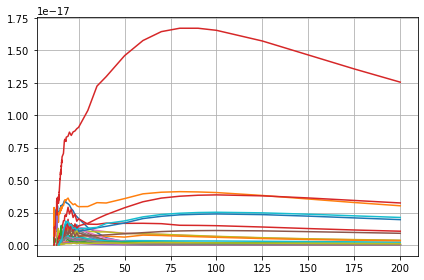

In [8]:
file_list = []
avgs = np.full(3, 0.)
#Inelastic differential cross sections
level = [11,13,14]
for ex_level in [11, 13, 14]:
#for ex_level in [11]:
    file_list.append(glob.glob(f'diff-cross-sections/{database}/inelastic_{ex_level}*.txt'))

#sigma_ex = np.full((3, eV_steps, angle_steps+angle_steps), 0.)
#print(sigma_ex)
np.seterr('raise')
sigma_ex_int = np.full((3, eV_steps),0.)
sigma_ex_int_tot = np.zeros(eV_steps)
sigma_ex_tot = np.zeros((eV_steps,angle_steps))
angle_size = np.arange(len(angle_list))
eV_size = np.arange(len(eV_list))
eV_int = 0.0
#print(file_list)
sigma_level = []
energy_vals = []
sigma_func = []
total_eVs = []
for i in np.arange(3):
#for i in np.arange(1):
    file_list[i].sort()
#print(file_list)
for k, file_group in enumerate(file_list):
    file_num = 0
    reduced_eVs = [0]*len(file_group)
    sigma_sum = []
    #print(reduced_eVs)
    for file in file_group:
        num_files = len(file_group)
        x_temp, y_temp, z_temp = np.loadtxt(file, unpack=True)
        z_temp *= 1e4
        energy = float(re.search(r'\d*\.\d*', file)[0])
        angle = 0
        for i in np.arange(len(z_temp)):
            angle_rad = (math.pi/180.0)*angle
            angle_1 = angle-1
            momt = (energy)/y_temp[i]
            cost = -math.pi*(math.cos(0) - math.cos((math.pi)/180.0))*(momt*math.cos(0) + momt*math.cos((math.pi)/180.0) - 2.0)
            if(angle > 0):
                cost = -math.pi*(math.cos((angle_1*math.pi)/180.0) - math.cos((angle*math.pi)/180.0))*(momt*math.cos((angle_1*math.pi)/180.0) + momt*math.cos((angle*math.pi)/180.0) - 2.0)
                #if(y_temp[i] == 100):
                    #print(cost)
                #cost = 2.0*math.pi*(0.25*(-math.cos((angle_1*math.pi)/90.0) - 4.0*math.cos((angle*math.pi)/180.0) + math.cos((angle*math.pi)/90.0)) + math.cos((angle_1*math.pi)/180.0))
            z_temp[i] *= cost
            #if(y_temp[i] == 100):
                #print(angle)
                #print(z_temp[i])
            angle += 1
            if(angle == 181.0):
                angle = 0.0
        reduced_eVs[file_num] = y_temp[::181]
        #reduced_inel = np.delete(reduced_inel,0)
        #print(reduced_eVs)
        sum_xsec = np.add.reduceat(z_temp, np.arange(0,len(z_temp), 181))
        #sum_xsec *= 1.0/(4.0*math.pi)
        if(file_num==0):
            min_e = y_temp[0]
            sigma_ex = [0]*num_files
            total_e_values = reduced_eVs[file_num]
            energy_vals.append(reduced_eVs[file_num])
            num_files_with_e = np.full(len(total_e_values),0.0)
            #print(len(reduced_eVs[file_num]))
            #print(len(total_e_values))
            total_eVs.append(total_e_values)
            #print(total_e_values)
        #sigma_ex[file_num] = np.full((len(reduced_eVs[file_num]), angle_steps+3),0.)
        sigma_ex[file_num] = np.full((len(reduced_eVs[0]), angle_steps+3),0.)
        #print(sigma_ex[0][0,0])
        #sigma_inel_func = np.delete(sigma_inel_func,len(sigma_inel_func)-1)
        #print(sum_xsec)
        #angle_lists = np.arange(181)
        #print(len(angle_lists))
        #print(angle_lists)
        counter = 0
        #print(len(sigma_ex))
        sigma_plot = np.full(len(reduced_eVs[0]), 0.0)
        #for i in np.arange(len(reduced_eVs[file_num])):
        energy_skip = 0
        for i in np.arange(len(reduced_eVs[0])):
            if(reduced_eVs[0][i] not in reduced_eVs[file_num]):
                sigma_ex[file_num][i,0] = reduced_eVs[0][i]
                sigma_plot[i] = 0.0
                energy_skip += 1
                continue
            for j in np.arange(angle_steps+3):
                if(j == 0):
                    #sigma_ex[file_num][i,j] = reduced_eVs[file_num][i]
                    sigma_ex[file_num][i,j] = reduced_eVs[0][i]
                elif(j == 1):
                    #sigma_ex[file_num][i,j] = sum_xsec[i]
                    sigma_ex[file_num][i,j] = sum_xsec[i-energy_skip]
                    #sigma_plot[i] = sum_xsec[i]
                    sigma_plot[i] = sum_xsec[i-energy_skip]
                else:
                    #sigma_ex[file_num][i,j] = z_temp[counter]/sum_xsec[i] 
                    sigma_ex[file_num][i,j] = z_temp[counter]/sum_xsec[i-energy_skip]
                    counter += 1
        sigma_sum.append(np.zeros(len(reduced_eVs[0])))
        #print(sigma_sum)
        for n in np.arange(len(total_e_values)):
            e_val = total_e_values[n]
            if(e_val in sigma_ex[file_num]):
                sigma_sum[0][n] += sigma_plot[n]
                if(sigma_plot[n] > 0.0):
                    num_files_with_e[n] += 1
        #print(num_files_with_e)
        #print(sigma_ex)
        #plt.plot(reduced_eVs[file_num], sigma_plot, label=energy)
        plt.plot(reduced_eVs[0], sigma_plot, label=energy)
        #for i in np.arange(len(reduced_eVs[0])):
            #print(sum(sigma_ex[file_num][i]) - reduced_eVs[0][i] - sigma_ex[file_num][i,1])
        #prinnp.add.reduceat(z_temp, np.arange(0,len(z_temp),len(angle_list)))
       
        
        #interp_func = interpolate.interp2d(x_temp, y_temp, z_temp, kind='linear', bounds_error=False, fill_value=(0., 0.))
        #interp_func = interpolate.griddata(x_temp, y_temp, z_temp, method='linear')
        #print(interp_func)
        #interp_func = interpolate.bisplrep(x_temp, y_temp, z_temp, s=0)
        #interp_func = interpolate.SmoothBivariateSpline(x_temp, y_temp, z_temp)
        #print(interp_func(angle_list,eV_list))
        #print(float(interp_func(angle_list,eV_list)))
        file_num += 1
        avgs[k] += float(re.search(r'\d*\.\d*', file)[0])
    #print(reduced_eVs)
    #print(sigma_ex[0])
    for num in np.arange(1,num_files):
        #for val in np.arange(len(reduced_eVs[num])):
        for val in np.arange(len(reduced_eVs[0])):
            e_val = reduced_eVs[0][val]
            if(e_val in sigma_ex[num]):
                #for i in np.arange(len(reduced_eVs[num])):
                for j in np.arange(angle_steps+3):
                    if(j == 1):
                        sigma_ex[0][val,j] += sigma_ex[num][val,j]
                    if(j >= 2):
                        sigma_ex[0][val,j] += sigma_ex[num][val,j]
                #sigma_sum[0][val] += sigma_sum[num][val]
    #print(reduced_eVs[0])
    for val in np.arange(len(total_e_values)):
        for j in np.arange(angle_steps+3):
            if(j >= 2):
                sigma_ex[0][val][j] /= num_files_with_e[val]
    #for i in np.arange(len(reduced_eVs[0])):
        #print(sum(sigma_ex[0][i]) - reduced_eVs[0][i] - sigma_ex[0][i,1])
    sigma_func.append(np.zeros(len(reduced_eVs[0])))
    for val in np.arange(len(total_e_values)):
        #sigma_func[k][val] = sigma_ex[0][val,1]
        sigma_func[k][val] = sigma_sum[0][val]
    #print(sigma_func[k])
    #print(len(sigma_func[k]))
    #print(sigma_ex[0])
        #for i in eV_size:
        #    for j in angle_size:
        #        eV_int += float(interp_func(angle_list[j],eV_list[i])) * 1e4
                #sigma_ex[k] += interp_func(eV_list) * 1e4
        #        sigma_ex[k,j,i] += float(interp_func(angle_list[j], eV_list[i])) * 1e4
            #print(eV_int)
        #    sigma_ex_int[k,i] += eV_int
        #    sigma_ex_tot += eV_int
            #eV_int = 0.
        #sigma_ex_int[k] += interp_func(eV_list) * 1e4
        #sigma_ex_int_tot += float(interp_func(angle_list, eV_list)) * 1e4
        #sigma_ex_tot += interp_func(eV_list) * 1e4
    
    sigma_level.append(sigma_ex[0])
#print(sigma_level)
#eV_min = 11.00
#eV_max = 200.00
#plt.xlim(eV_min, eV_max)
#plt.xscale('log')
#plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The below cell condenses the given excitation cross-sections into four energy bands.

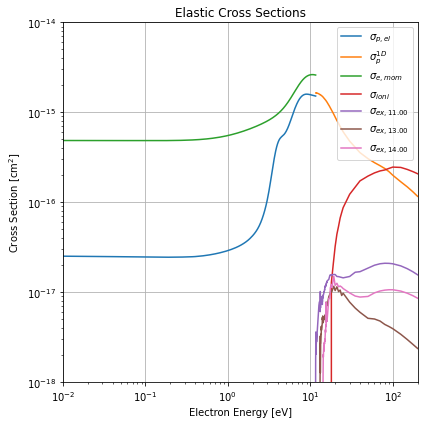

In [9]:
fig = plt.figure(figsize=(6,6))
plt.plot(reduced_list_p, sigma_p_func, label=r'$\sigma_{p,el}$')
plt.plot(sigma_p_eVs_1D_sub, sigma_p_1D_sub, label=r'$\sigma_{p}^{1D}$')
plt.plot(reduced_list_e, sigma_e_func, label=r'$\sigma_{e,mom}$')
plt.plot(sigma_ioni_eVs, sigma_ioni, label=r'$\sigma_{ioni}$')

#plt.plot(reduced_inel, sigma_inel_func, label=r'$\sigma_{p,inel}$')
for k in np.arange(len(sigma_func)):
    plt.plot(total_eVs[k], sigma_func[k], label=f'$\sigma_{{ex,{level[k]:.2f}}}$')

#plt.plot(eV_list, sigma_ex_int_tot, 'g', label='$\sigma_{ex,tot}$')
#eV_min = min(reduced_list)
#eV_max = max(reduced_list)
#plt.xlim(eV_min, eV_max)

plt.xlabel('Electron Energy [eV]')
plt.ylabel('Cross Section [cm$^2$]')

#plt.title('Excitation Cross Sections')
plt.title('Elastic Cross Sections')

plt.ylim([1e-18,1e-14])
plt.xlim(1e-2,2e+2)
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The cell below show all cross-sections together.

In [ ]:
plt.plot(reduced_list, sigma_p_func, label=r'$\sigma_p$')
#plt.plot(eV_list, final_sigma_e(eV_list), label=r'LAr $\sigma_E$')
#plt.plot(eV_list, final_sigma_p(eV_list), label=r'LAr $\sigma_p$')

#plt.plot(eV_list, sigma_i_func(eV_list), label=r'$\sigma_I$')

#for k, ex_level in enumerate(sigma_ex):
#    plt.plot(eV_list, ex_level, label=f'$\sigma_{{ex,{avgs[k]:.2f}}}$')

plt.xlabel('Energy [eV]')
plt.ylabel(r'Cross-Section [cm$^2$]')

plt.title('Ar Elastic Scattering Cross-Section')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The below cell calculates and shows each cross-section multiplied by the electron velocity corresponding to the $x$-axis kinetic energy. These values are used to calculate the probability of scattering events. $K_\mathrm{max}$ is taken to be the peak of the sum of these values.

In [ ]:
#compos_x_sec = np.array([])
#for i, e in enumerate(eV_list):
#    compos_x_sec = np.append(compos_x_sec, max(final_sigma_e(e), final_sigma_p(e) + sigma_ex_tot[i]))

#plt.plot(eV_list, sigma_p_func(eV_list) * E_to_v(eV_list) * 1e2, label=r'GAr $v\sigma_p$')
#plt.plot(eV_list, (sigma_p_func(eV_list) + sigma_ex_tot) * E_to_v(eV_list) * 1e2, label=r'GAr $v\sigma_{total}$')

#plt.plot(eV_list, compos_x_sec * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{total}$')

#plt.plot(eV_list, final_sigma_e(eV_list) * E_to_v(eV_list) * 1e2, label=r'$v\sigma_E$')
#plt.plot(eV_list, final_sigma_p(eV_list) * E_to_v(eV_list) * 1e2, label=r'$v\sigma_p$')

#plt.plot(eV_list, sigma_i_func(eV_list) * E_to_v(eV_list) * 1e2, label=r'$v\sigma_I$')
#plt.plot(eV_list, sigma_ex[0] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{11}}$')
#plt.plot(eV_list, sigma_ex[1] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{13}}$')
#plt.plot(eV_list, sigma_ex[2] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{14}}$')
#plt.plot(eV_list, sigma_ex[3] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{15}}$')

#plt.xlabel('Energy [eV]')
#plt.ylabel(r'Velocity $\times$ Cross-Section [cm$^3$/s]')

#K_max = round(np.amax(compos_x_sec * E_to_v(eV_list) * 1e2) * 1.01, 9)
#plt.plot(np.logspace(-3, 3, 10), np.full(10, K_max), 'k--', label='$K_{\mathrm{max}}$')
#plt.title(f'Determination of $K_{{\mathrm{{max}}}}$')

#plt.xscale('log')
#plt.yscale('log')

#plt.legend(loc=3)
#plt.grid()
#plt.tight_layout()
#plt.show()

This final cell generates the LUTs used by the simulation.

In [10]:
if os.path.exists("../../src/LUTs/DiffCrossSectionsLAr.h"):
    os.remove("../../src/LUTs/DiffCrossSectionsLAr.h")

header = open("../../src/LUTs/DiffCrossSectionsLAr.h", "a+")

np.savetxt(header, [], comments="", header=f"#ifndef DIFFCROSSSECTIONSLAR_H\n#define DIFFCROSSSECTIONSLAR_H\n\nconst double eV_min_liq_diff = {eV_min};\nconst double eV_max_liq_diff = {eV_max};\nconst int eV_steps_liq_diff = {eV_steps};\nconst double angle_min_liq_diff = 0.0;\nconst double angle_max_liq_diff = 180.0;\nconst int angle_steps_liq_diff = 180.0;\n");#\nconst double K_max = {K_max};\n\nconst double effective_xsec_liquid[] = {{")
#np.savetxt(header, final_sigma_e(eV_list), newline=",")
#np.savetxt(header, [], comments="", header="\n};\n\nconst double momentum_xsec_liquid[] = {")
#np.savetxt(header, final_sigma_p(eV_list), newline=",")
np.savetxt(header, [], comments="", header="\n\nconst double energy_vals_liq_diff[] = {")
np.savetxt(header,np.append(reduced_list_p,sigma_p_eVs_1D_sub) , newline=",",fmt='%.2e')
np.savetxt(header, [], comments="", header="\n};\n\nconst double angle_vals_liq_diff[] = {")
np.savetxt(header,angle_lists, newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double momentum_xsec_liq_diff[] = {")
for i in np.arange(len(entry_p)):
    np.savetxt(header, entry_p[i], newline=",",fmt='%.2e')
np.savetxt(header, [], comments="", header="\n};\n\nconst double energy_xsec_liq_diff[] = {")
for i in np.arange(len(entry_e)):
    np.savetxt(header, entry_e[i], newline=",",fmt='%.2e')
#np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_11_diff[] = {")
#for i in np.arange(len(sigma_level[0])):
#    np.savetxt(header, sigma_level[0][i], newline=",",fmt='%.2e')
#np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_13_diff[] = {")
#for i in np.arange(len(sigma_level[1])):
#    np.savetxt(header, sigma_level[1][i], newline=",",fmt='%.2e')
#np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_14_diff[] = {")
#for i in np.arange(len(sigma_level[2])):
#    np.savetxt(header, sigma_level[2][i], newline=",",fmt='%.2e')
#np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_15[] = {")
#np.savetxt(header, sigma_ex[3], newline=",")
#np.savetxt(header, [], comments="", header="\n};\n\nconst double ionization_xsec[] = {")
#np.savetxt(header, sigma_ioni_func(eV_list), newline=",",fmt='%.2e')
np.savetxt(header, [], comments="", header="\n};\n\n#endif")

header.close()

In [11]:
print (len(entry_e[1]))
#print (entry_p[1])
#print (entry_p[2])

183


In [12]:
365-183-183

-1

In [13]:
print (reduced_list_p)

[2.000e-03 4.000e-03 6.000e-03 8.000e-03 1.000e-02 2.000e-02 3.000e-02
 4.000e-02 5.000e-02 6.000e-02 7.000e-02 8.000e-02 9.000e-02 1.000e-01
 1.100e-01 1.200e-01 1.300e-01 1.400e-01 1.500e-01 1.600e-01 1.700e-01
 1.800e-01 1.900e-01 2.000e-01 2.100e-01 2.200e-01 2.300e-01 2.400e-01
 2.500e-01 2.600e-01 2.700e-01 2.800e-01 2.900e-01 3.000e-01 3.100e-01
 3.200e-01 3.300e-01 3.400e-01 3.500e-01 3.600e-01 3.700e-01 3.800e-01
 3.900e-01 4.000e-01 4.500e-01 5.000e-01 5.500e-01 6.000e-01 6.500e-01
 7.000e-01 7.500e-01 8.000e-01 8.500e-01 9.000e-01 9.500e-01 1.000e+00
 1.050e+00 1.100e+00 1.150e+00 1.200e+00 1.250e+00 1.300e+00 1.350e+00
 1.400e+00 1.450e+00 1.500e+00 1.550e+00 1.600e+00 1.650e+00 1.700e+00
 1.750e+00 1.800e+00 1.850e+00 1.900e+00 1.950e+00 2.000e+00 2.050e+00
 2.100e+00 2.150e+00 2.200e+00 2.250e+00 2.300e+00 2.350e+00 2.400e+00
 2.450e+00 2.500e+00 2.550e+00 2.600e+00 2.650e+00 2.700e+00 2.750e+00
 2.800e+00 2.850e+00 2.900e+00 2.950e+00 3.000e+00 3.050e+00 3.100e+00
 3.150